In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

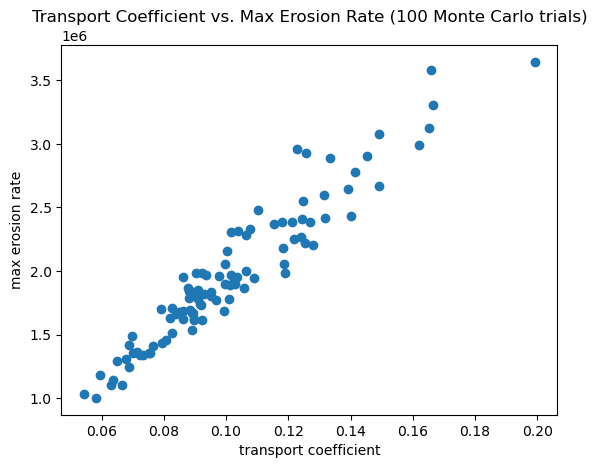

In [33]:
# transport coeff vs. max erosion rate
df = pd.read_csv("River-Unity/Results/summary_statistics.csv")
transport_coeff = df["transport_coefficient_K"]
max_erosion_rate = df["max_erosion_rate"]

plt.scatter(transport_coeff, max_erosion_rate)
plt.xlabel("transport coefficient")
plt.ylabel("max erosion rate")
plt.title("Transport Coefficient vs. Max Erosion Rate (100 Monte Carlo trials)")
plt.show()

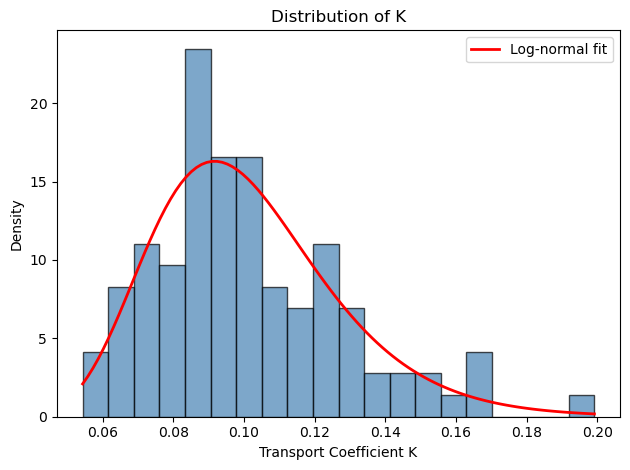

K-S p=0.7815, Shapiro p=0.6526 -> Log-normal confirmed


In [34]:
# verifying that 100 trials is enough for transport coeff to follow the log-normal distribution
K = df['transport_coefficient_K'].values
ln_K = np.log(K)

# Histogram of K
plt.hist(K, bins=20, density=True, alpha=0.7, color='steelblue', edgecolor='black')
x_fit = np.linspace(K.min(), K.max(), 100)
mu_ln, sigma_ln = ln_K.mean(), ln_K.std()
pdf_fit = stats.lognorm.pdf(x_fit, s=sigma_ln, scale=np.exp(mu_ln))
plt.plot(x_fit, pdf_fit, 'r-', lw=2, label=f'Log-normal fit')
plt.xlabel('Transport Coefficient K')
plt.ylabel('Density')
plt.title('Distribution of K')
plt.legend()

plt.tight_layout()
plt.show()

mu, sigma = ln_K.mean(), ln_K.std()

ks_p = stats.kstest(ln_K, 'norm', args=(mu, sigma))[1]
sw_p = stats.shapiro(ln_K)[1]

print(f"K-S p={ks_p:.4f}, Shapiro p={sw_p:.4f} -> {'Log-normal confirmed' if ks_p > 0.05 and sw_p > 0.05 else 'Not log-normal'}")

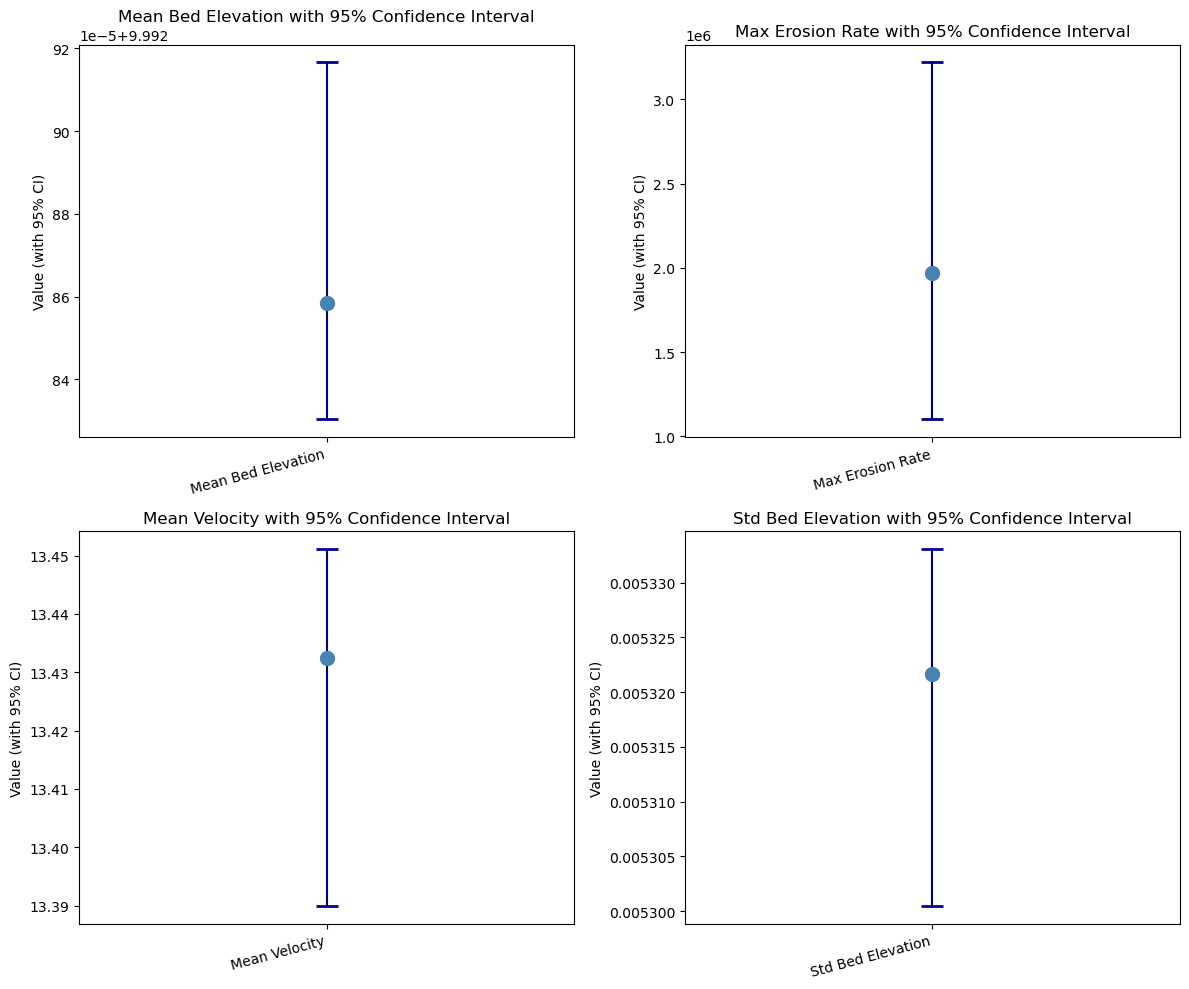


95% Confidence Intervals:
mean_bed_elevation       : 9.992858 [9.992830, 9.992917]
max_erosion_rate         : 1969911.916586 [1102589.324528, 3219283.486780]
mean_velocity            : 13.432410 [13.389961, 13.451091]
std_bed_elevation        : 0.005322 [0.005300, 0.005333]


In [35]:
metrics = ['mean_bed_elevation', 'max_erosion_rate', 'mean_velocity', 'std_bed_elevation']
metric_labels = ['Mean Bed Elevation', 'Max Erosion Rate', 'Mean Velocity', 'Std Bed Elevation']

ci_results = []
for metric in metrics:
    data = df[metric].values
    ci_results.append({
        'metric': metric,
        'mean': np.mean(data),
        'std': np.std(data),
        'ci_lower': np.percentile(data, 2.5),
        'ci_upper': np.percentile(data, 97.5),
        'median': np.median(data)
    })

ci_df = pd.DataFrame(ci_results)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    data = df[metric].values
    axes[i].errorbar(0, np.mean(data), 
                     yerr=[[np.mean(data) - np.percentile(data, 2.5)], 
                           [np.percentile(data, 97.5) - np.mean(data)]],
                     fmt='o', markersize=10, capsize=8, capthick=2, 
                     color='steelblue', ecolor='darkblue')

    axes[i].set_xticks([0])
    axes[i].set_xticklabels([metric_labels[i]], rotation=15, ha='right')
    axes[i].set_ylabel('Value (with 95% CI)')
    axes[i].set_title(f'{metric_labels[i]} with 95% Confidence Interval')

# Adjust layout
plt.tight_layout()
plt.savefig('confidence_intervals_grid.png', dpi=150, bbox_inches='tight')
plt.show()

# Print table
print("\n95% Confidence Intervals:")
print("="*70)
for _, row in ci_df.iterrows():
    print(f"{row['metric']:25s}: {row['mean']:.6f} [{row['ci_lower']:.6f}, {row['ci_upper']:.6f}]")

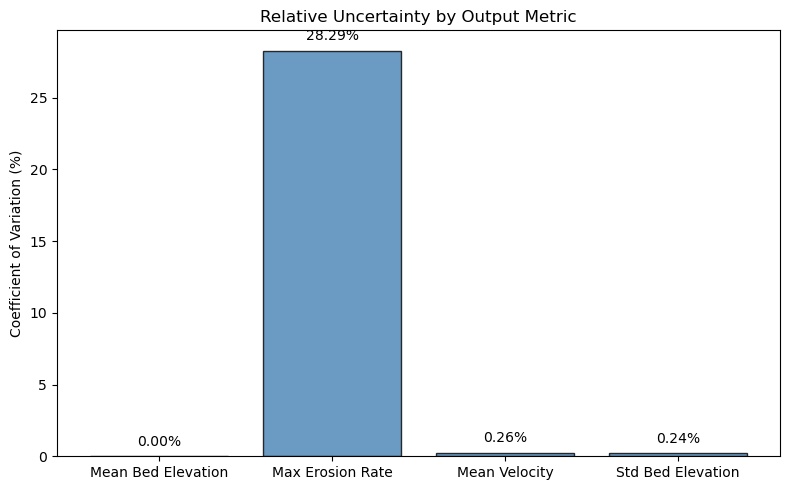

Coefficient of Variation (CV = σ/μ × 100%):
  mean_bed_elevation: 0.0002%
  max_erosion_rate: 28.2876%
  mean_velocity: 0.2601%
  std_bed_elevation: 0.2405%


In [36]:
# coefficient of variation
# compare relative uncertainty (CV = σ/μ) across output metrics

# metrics = ['mean_bed_elevation', 'std_bed_elevation', 'max_erosion_rate', 'mean_velocity']
# metric_labels = ['Mean Bed\nElevation', 'Std Bed\nElevation', 'Max Erosion\nRate', 'Mean\nVelocity']

cv_values = []
for metric in metrics:
    data = df[metric].values
    cv = np.std(data) / np.mean(data) * 100  # as percentage
    cv_values.append(cv)

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(metric_labels, cv_values, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_ylabel('Coefficient of Variation (%)')
ax.set_title('Relative Uncertainty by Output Metric')

# Add value labels on bars
for bar, cv in zip(bars, cv_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{cv:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('4_coefficient_of_variation.png', dpi=150, bbox_inches='tight')
plt.show()

print("Coefficient of Variation (CV = σ/μ × 100%):")
for m, cv in zip(metrics, cv_values):
    print(f"  {m}: {cv:.4f}%")